In [159]:
%matplotlib inline
import sympy
import numpy as np
import astropy.units as u
import uncertainties as unc
import uncertainties.unumpy as unp
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar, fsolve
from fact.analysis import li_ma_significance
sympy.init_printing()

## Sensitivity Calculation
The sensitvity of an IACT is defined as the minimum flux needed to observe a (point) source with a significance of least $\sigma_{target}$ within a fixed amount of time $t_{ref}$.
After analysing the high-level IACT data you're left with the number of events from the source region from the sky and the number of events from the background region in the sky. Namely $N_{on}$ and  $N_{off}$. Usually, if not always, the source and background regions have different sizes. The ration between these is called $\alpha$.

The good old Li&Ma formula calculates the significance of an observation based on the numbers above. To calculate the sensitivity we scale the number of 'gamma' events by the relative flux. 

All other counts are scaled taking into account the reference time (i.e. 50 hours) 
and the actual observation time (which of course only really defined for real observations)

The target significance is pre defined and fixed (usually set to 5 sigma). So we create an equality between the target sigma and the scaled Li&Ma formula and solve for the flux.

In [160]:
#target_significance = sympy.Symbol('\sigma_\mathrm{target}')
#eq = sympy.Equality(scaled_li_ma, target_significance)

Calling `sympy.solve(eq, relative_flux)`, to solve for the relative flux, yields no solution unfortunately. So we use a numerical minimizer to solve the problem. To help find a good minimizer lets plot the Li&Ma significance and the target function. Obviously the minimizer doesnt work in this case.

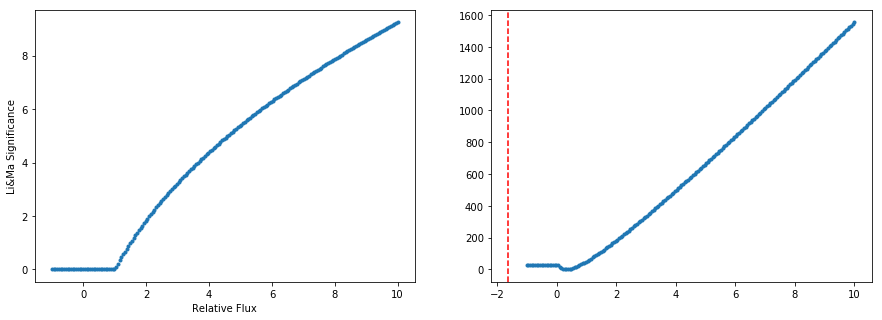

In [161]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 5))

off=np.ones(200) * 10 # keep off counts constant

parameter = np.linspace(-1, 10, 200)
s = li_ma_significance(10 * parameter, off, alpha=1)

ax1.plot(parameter, s, '.')
ax1.set_ylabel('Li&Ma Significance')
ax1.set_xlabel('Relative Flux')

target_significance = 5
f = lambda relative_flux: (target_significance - li_ma_significance(150 * relative_flux, off, alpha=1))**2
ax2.plot(parameter, f(parameter), '.')

# # lets eee if a minimizer finds the minimum
minimum = minimize_scalar(f)
ax2.axvline(minimum.x, color='red', linestyle='dashed')

We need a significance function that is continuos and differentiable. Lets try to modifiy the Li&Ma method accordingly. 

In [162]:
# def differentiable_li_ma_significance(n_on, n_off, alpha=1):
#     scalar = np.isscalar(n_on)
    
#     n_on = np.array(n_on, copy=False, ndmin=1)
#     n_off = np.array(n_off, copy=False, ndmin=1)
    
#     # find the indeces in the array for which the sign should be flipped
#     m = n_on < n_off*alpha
    
#     p_on = n_on / (n_on + n_off)
#     p_off = n_off / (n_on + n_off)

#     t1 = n_on * np.log(((1 + alpha) / alpha) * p_on)
#     t2 = n_off * np.log((1 + alpha) * p_off)

#     ts = (t1 + t2)
#     significance = np.sqrt(ts * 2)
#     if len(m)> 0:
#         significance[m] = -significance[m]
#     if scalar:
#         return significance[0]
#     return significance


Or simply add bounds to the optimizer.

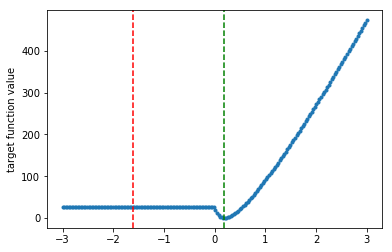

In [169]:
on = 200
off = 10
parameter = np.linspace(-3, 3, 200)
f = lambda relative_flux: (target_significance - li_ma_significance((on - off) * relative_flux + off, off, alpha=1))**2
plt.plot(parameter, f(parameter), '.')
plt.ylabel('target function value')

# lets see if a minimizer finds the minimum
minimum = minimize_scalar(f)
plt.axvline(minimum.x, color='red', linestyle='dashed')

minimum = minimize_scalar(f, bounds=(1e-10, 100), method='bounded')
plt.axvline(minimum.x, color='green', linestyle='dashed')

Below you will find a function implementing the Li&Ma formula and a function minimizing the function versus the target significance of 5 sigma. 

In [195]:
@u.quantity_input(t_obs=u.hour, t_ref=u.hour)
def relative_sensitivity(
        n_on,
        n_off,
        alpha,
        target_significance=5,
        ):
    '''
    Calculate the relative sensitivity defined as the flux
    relative to the reference source that is detectable with
    significance in t_ref.

    Parameters
    ----------
    n_on: int or array-like
        Number of signal-like events for the on observations
    n_off: int or array-like
        Number of signal-like events for the off observations
    alpha: float
        Scaling factor between on and off observations.
        1 / number of off regions for wobble observations.
    target_significance: float
        Significance necessary for a detection
        
    Returns
    ----------
    The relative flux neccessary to detect the source with the given target significance.
    '''
    scale = []
    for on, off in zip(n_on, n_off):
        if on < off*alpha or off == 0:
            scale.append(np.inf)
            continue
        def f(relative_flux):
            s = (target_significance - li_ma_significance((on - off) * relative_flux + off, off, alpha=alpha))**2
            return s

        s = minimize_scalar(f, bounds=(1e-12, 100), method='bounded')

        scale.append(s.x)
    return scale

In [196]:
n_on =  [4, 1, 200, 400, 50, 200, 20000]
n_off = [2, 0, 10, 10, 10, 10, 10]

s = relative_sensitivity(n_on, n_off, alpha=1, target_significance=5)
print('relative sensitivity is: {}'.format(s))

relative sensitivity is: [12.239475768994886, inf, 0.18904943918602754, 0.09210194632997426, 0.89798928277450285, 0.18904943918602754, 0.0017985381089989318]
